# Monte Carlo 2D Ising Model: Heat Bath Algorithm

NxN spins, B = 0, J = 1, k = 1

In [1]:
from math import *
from random import *
import numpy as np
import matplotlib.pyplot as plt

Some basic conditions (to test functions & debugging):

In [2]:
N = 10 #length of ising model
I = np.ones((N,N)) #all spins up, periodic bounday conditions
T = 3 #final temp, near critical region
beta_0 = 1/T #make k = 1 here for simplicity
print(I)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [3]:
I = [[1,2,3],[4,5,6],[7,8,9]]
print(I)
I = np.asarray(I)
print(I)
for i in range(len(I)):
    for j in range(len(I)):
        print(I[i,j])

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]
[[1 2 3]
 [4 5 6]
 [7 8 9]]
1
2
3
4
5
6
7
8
9


Defining functions that calculate internal energy, flip a spin, and energy change when flipping a spin:

In [4]:
def E(ising_array): #gets energy in 2D ising array, must have more than 2 by 2 grid.
    total_E = 0
    for i in range(len(ising_array)):
        for j in range(len(ising_array)):
            total_E += -ising_array[i, j]*ising_array[(i+1)%len(ising_array), j] - ising_array[i, j]*ising_array[i, (j + 1)%len(ising_array)] #periodic sum
    return total_E

In [5]:
def M(ising_array): #gets magnetization in ising array
    total_M = 0
    for i in range(len(ising_array)):
        for j in range(len(ising_array)):
            total_M += ising_array[i,j]
    return total_M

In [6]:
def flip(ising_array, n, m): #just flips spin in position (n, m)
    ising_array[n, m] = -ising_array[n, m]  #updated array
    return 0

In [7]:
def flip_dE(ising_array, n, m): #energy change when flipping spin in position (n,m)
    dE = 2*ising_array[n,m]*(ising_array[n,(m-1)%len(ising_array)]+ising_array[n,(m+1)%len(ising_array)]+ising_array[(n+1)%len(ising_array),m] + ising_array[(n-1)%len(ising_array),m])
    return dE

In [8]:
def flip_dM(ising_array, n, m): #magnetization change when flipping a spin
    return -2*ising_array[n, m]

In [9]:
def auto_correlation(m, t_max, t): #returns chi(t), needed to measure integrated correlation time
    sum1 = 0
    sum2 = 0
    sum3 = 0
    
    for i in range(t_max - t):
        #print(i+t)
        sum1 += m[i] * m[i + t]
        
        
    for i in range(t_max - t):
        sum2 += m[i]
        
    for i in range(t_max - t):
        sum3 += m[i + t]
        
    return sum1/(t_max - t) - sum2 * sum3 / (t_max - t)**2

In [10]:
def corr_time(chi_list):
    tau = 0
    
    for i in range(len(chi_list)):
        tau += chi_list[i]/chi_list[0]
    
    return tau

Using the above functions, we can apply the heat bath algorithm to N randomly
chosen spins (sweep):

In [11]:
def cycle(ising_array, beta): #does 1 sweep
    for k in range(len(ising_array) ** 2): 
        i = randint(0, len(ising_array) - 1)
        j = randint(0, len(ising_array) - 1) #random (i, j) spin is chosen
        
        d_E = flip_dE(ising_array, i, j)
        
        A = np.exp(-0.5 * beta * d_E)/(np.exp(-0.5 * beta * d_E) + np.exp(0.5 * beta * d_E))
      
        if(random() < A):
                flip(ising_array, i, j) #much more likely to transition down than up...
                
                
    return [E(I), M(I)]

In [12]:
def m_cycle(ising_array, beta): #does 1 sweep, metropolis!
    for k in range(len(ising_array) ** 2): 
        i = randint(0, len(ising_array) - 1)
        j = randint(0, len(ising_array) - 1) #random (i, j) spin is chosen
        
        d_E = flip_dE(ising_array, i, j)
        
        A = np.exp(-beta*d_E)
        
        if(d_E < 0):
            flip(ising_array, i, j) 
            
      
        else:
            if(random() < A):
                flip(ising_array, i, j) #much more likely to transition down than up...
                
                
    return [E(I), M(I)]

Acceptance ratio plot for heat bath algorithm:

Text(0, 0.5, 'Acceptance Ratio')

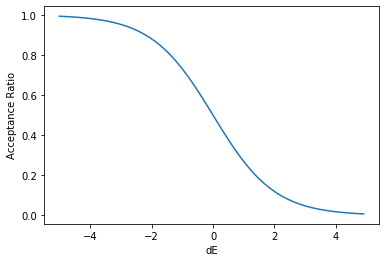

In [13]:
def A(d_E):
    beta = 1
    return np.exp(-0.5 * beta * d_E)/(np.exp(-0.5 * beta * d_E) + np.exp(0.5 * beta * d_E))

x = np.arange(-5,5, 0.1)
y = A(x)
plt.plot(x,y)
plt.xlabel("dE")
plt.ylabel("Acceptance Ratio")

In [14]:
5%3

2

Running a simulation to equilibrium conditions takes around 1000 sweeps (possibly more for low T),
since the simulation is longer near the critical region (where the phase 
transition from ferromagnet to paramegnet occurs)

In [15]:
def simulation(ising_array, beta): #returns energy and magnetization
    E_list = []
    m_list = []
    for i in range(1000):
        E_element, M_element = cycle(I, beta)
        if(i > 200 and i%10 == 0):
            m_list.append(M_element/len(I))
            E_list.append(E_element)
                
    return [E_list, m_list]

In [30]:
def m_simulation(ising_array, beta): #simulation but with metropolis
    E_list = []
    m_list = []
    for i in range(10000):
        E_element, M_element = m_cycle(I, beta)
        if(i > 1000 and i%20 == 0):
            m_list.append(M_element/len(I))
            E_list.append(E_element)
                
    return [E_list, m_list]

In [17]:
I = np.ones((10,10))
I
a = simulation(I, 0.1)
I
np.average(a[0])

-23.443037974683545

In [18]:
I = np.ones((10,10))
I
a = m_simulation(I, 0.1)
I
np.average(a[0])

-20.535714285714285

To get <q^2>, just convert q_array to numpy array and then np.average(q_array**2). 

In [19]:
def simple_error(q_array): #gets the error for simple averaged parameters like energy, magnetization
    q_array = np.asarray(q_array)
    sigma = np.sqrt((np.average(q_array**2) - np.average(q_array)**2)/len(q_array))
    return sigma

In [20]:
def specific_heat(e_l, beta, spin_num): #gets specific heat from energy list
    e_l = np.asarray(e_l)
    return ((beta**2)/spin_num) * (np.average(e_l**2) - np.average(e_l)**2)

In [21]:
def c_bootstrap(e_l, beta, spin_num): #bootstrap error method, used to calculate specific heat error from overall energy list 
    e_l = np.asarray(e_l)
    c_list = []
    for i in range(10): #do this process 10 times
        temp_list = []
        for j in range(len(e_l)):
            index = randint(0, len(e_l)-1)
            temp_list.append(e_l[index])
        c_list.append(specific_heat(temp_list, beta, spin_num))
        #print(c_list) #troubleshoot
    c_list = np.asarray(c_list)
    sigma = np.sqrt(np.average(c_list**2) - np.average(c_list)**2)
    return sigma
        
    

In [22]:
list1 = [1,2,3,4,5]
list1[-2:]

[4, 5]

Getting integrated correlation time: Correlation time time is low when not near critical temperature, but becomes very large near critical temperature. For this code to work, we have to change the simulation function to record after each sweep.

In [23]:
b0 = 1/3
I = np.ones((10,10))

E_array = simulation(I, b0)[0]
m_array = simulation(I, b0)[1]

chi_array = []

for i in range(100): #get chi(0) to chi(300)
    chi_array.append(auto_correlation(m_array, 400, i))
    
t_array = np.arange(100)

plt.plot(t_array, chi_array)
plt.xlabel("Time (in sweeps)")
plt.ylabel("Magnetization autocorrelation")
plt.show()

print(corr_time(chi_array))

IndexError: list index out of range

In [24]:
print(simple_error(E_array))
I
print(np.average(E_array))

2.5096432134300373
-83.49367088607595


Comparing analytic to computationally determined energies at a variety of temperatures:

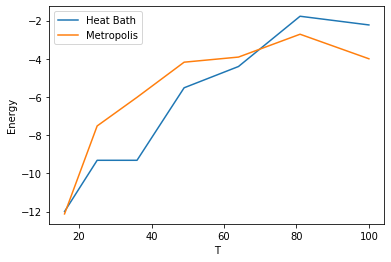

In [25]:
N = 10
T_array = np.asarray([16, 25, 36, 49, 64, 81, 100])
beta_array = 1/T_array #k = 1
E_analytic = -N**2 *np.tanh(1/T_array)

E_comp = [] #heat bath
m_E_comp = [] #metropolis

for i in range(len(T_array)):
    I = np.ones((N,N))
    E_comp.append(np.average(simulation(I, 1/T_array[i])[0]))
    m_E_comp.append(np.average(m_simulation(I, 1/T_array[i])[0]))
    
plt.plot(T_array, E_comp, label="Heat Bath")
plt.plot(T_array, m_E_comp, label="Metropolis")
plt.legend()
plt.xlabel("T")
plt.ylabel("Energy")
plt.show()


Calculating energy, magnetization, specific heat:

In [31]:
N = 20
T_array2 = np.linspace(0.1, 5, 25)
beta_array = 1/T_array2

E_comp = []
E_error = [] 
m_comp = []
m_error = []
c_comp = []
c_error = []#heat bath stuff

m_E_comp = []
m_E_error = []
m_m_comp = []
m_m_error = []
m_c_comp = []
m_c_error = []#metroplis

for i in range(len(T_array2)):
    I = np.ones((N, N))
    results = simulation(I, 1/T_array2[i]) #heat bath simulation
    
    energy_list = results[0]
    m_list = results[1]
    
    E_comp.append(np.average(energy_list))
    E_error.append(simple_error(energy_list)) #energy from heat bath
    
    m_comp.append(np.average(m_list))
    m_error.append(simple_error(m_list)) #magnetization from heat bath
    
    c_comp.append(specific_heat(energy_list, beta_array[i], len(I)))
    c_error.append(c_bootstrap(energy_list, beta_array[i], len(I))) #specific heat from heat bath
    
    I = np.ones((N, N))
    m_results =  m_simulation(I, 1/T_array2[i]) #metropolis algorithm
    
    m_energy_list = m_results[0]
    m_m_list = m_results[1]
    
    m_E_comp.append(np.average(m_energy_list))
    m_E_error.append(simple_error(m_energy_list)) #energy from metropolis
    
    m_m_comp.append(np.average(m_m_list))
    m_m_error.append(simple_error(m_m_list)) #magnetization from metropolis
    
    m_c_comp.append(specific_heat(m_energy_list, beta_array[i], len(I)))
    m_c_error.append(c_bootstrap(m_energy_list, beta_array[i], len(I))) #specific heat from metropolis


plt.errorbar(T_array2, E_comp, yerr = E_error, label="Heat Bath", color = "orange")
plt.errorbar(T_array2, m_E_comp, yerr = m_E_error, label="Metropolis", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Energy")
plt.title("Energy Plot")
plt.savefig("energy_2D.pdf")
plt.clf()

plt.errorbar(T_array2, m_comp, yerr = m_error, label="Heat Bath", color = "orange")
plt.errorbar(T_array2, m_m_comp, yerr = m_m_error, label="Metropolis", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Magnetization")
plt.title("Magnetization")
plt.savefig("magnetization_2D.pdf")
plt.clf()

plt.errorbar(T_array2, c_comp, yerr = c_error, label="Heat Bath", color = "orange")
plt.errorbar(T_array2, m_c_comp, yerr = m_c_error, label="Metropolis", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Specific Heat")
plt.title("Specific Heat")
plt.savefig("specific_heat_2D.pdf")
plt.clf()

<Figure size 432x288 with 0 Axes>

In [ ]:
c_comp

Calculating magnetization:

In [ ]:
N = 5
T_array2 = np.linspace(0.1, 5, 25)
m_comp = []
m_error = [] #heat bath

m_m_comp = []
m_m_error = [] #metropolis


for i in range(len(T_array2)):
    I = np.ones((N, N))
    m_list = simulation(I, 1/T_array2[i])[1]
    m_comp.append(np.average(m_list))
    m_error.append(simple_error(m_list)) #heat bath
    
    m_m_list = m_simulation(I, 1/T_array2[i])[1]
    m_m_comp.append(np.average(m_m_list))
    m_m_error.append(simple_error(m_m_list)) #metroplis
    

plt.errorbar(T_array2, m_comp, yerr = m_error, label="Heat Bath", color = "orange")
plt.errorbar(T_array2, m_m_comp, yerr = m_m_error, label="Metropolis", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Magnetization")
plt.show()


Calculating specific heat:

In [ ]:
N = 5
T_array2 = np.linspace(0.1, 5, 25)
beta_array = 1/T_array2
c_comp = []
c_error = [] #heat bath

m_c_comp = []
m_c_error = [] #metroplis

for i in range(len(T_array2)):
    I = np.ones((N, N))
    energy_list = simulation(I, 1/T_array2[i])[0]
    c_comp.append(specific_heat(energy_list, beta_array[i], len(I)))
    c_error.append(c_bootstrap(energy_list, beta_array[i], len(I)))
    
    m_energy_list = m_simulation(I, 1/T_array2[i])[0]
    m_c_comp.append(specific_heat(m_energy_list, beta_array[i], len(I)))
    m_c_error.append(c_bootstrap(m_energy_list, beta_array[i], len(I)))
    
    
plt.errorbar(T_array2, c_comp, yerr = c_error, label="Heat Bath", color = "orange")
plt.errorbar(T_array2, m_c_comp, yerr = m_c_error, label="Metropolis", color = "green")
plt.legend()
plt.xlabel("T")
plt.ylabel("Specific Heat")
plt.show()